# California House Prices — Comment‑Free ML Notebook

Simple markdown before each cell. Run top‑to‑bottom.

## Import libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

## Set data path

In [2]:
DATA_PATH = "/content/housing.csv"

## Load dataset

In [3]:
data = pd.read_csv(DATA_PATH)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Inspect info and missing values

In [4]:
print(data.shape)
print(data.isna().sum())
data.info()

(20640, 10)
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9)

## Drop rows with missing values

In [5]:
data = data.dropna().reset_index(drop=True)
print(data.shape)

(20433, 10)


## Split into features and target

In [6]:
target_col = "median_house_value"
X = data.drop(columns=[target_col])
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = pd.concat([X_train.copy(), y_train.copy()], axis=1)
train_data.shape

(16346, 10)

## Plot histograms for numeric features in training data

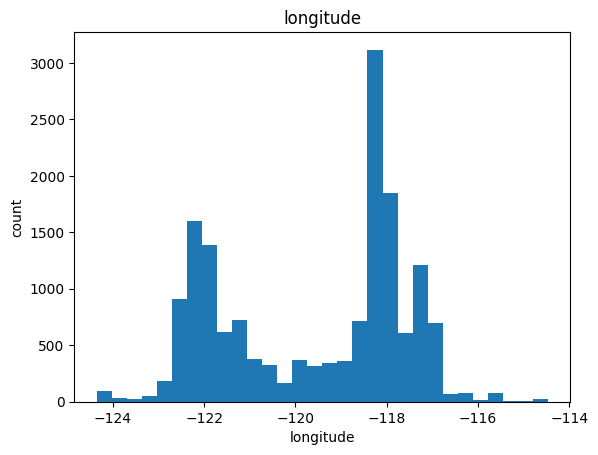

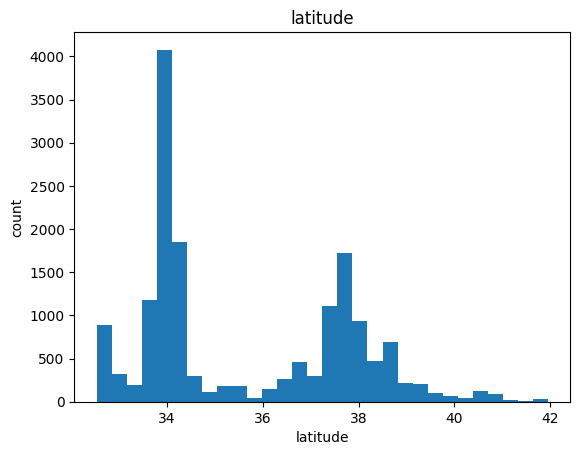

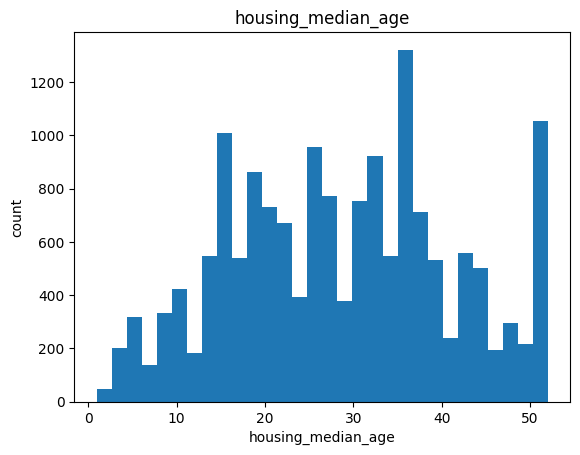

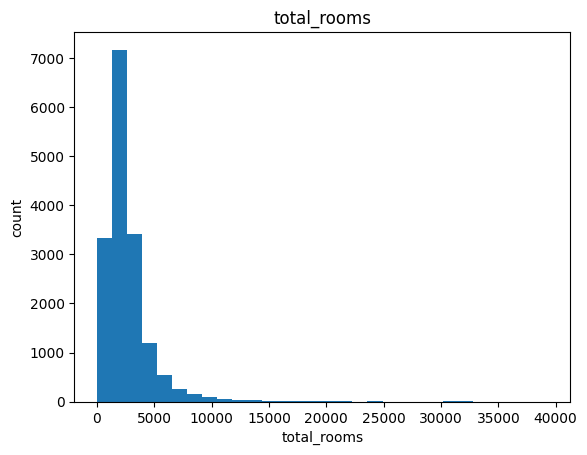

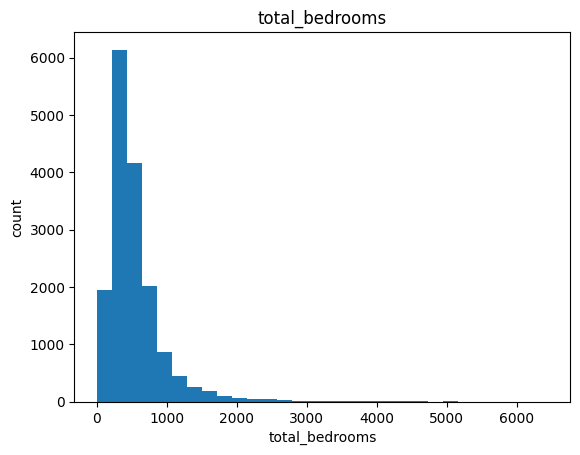

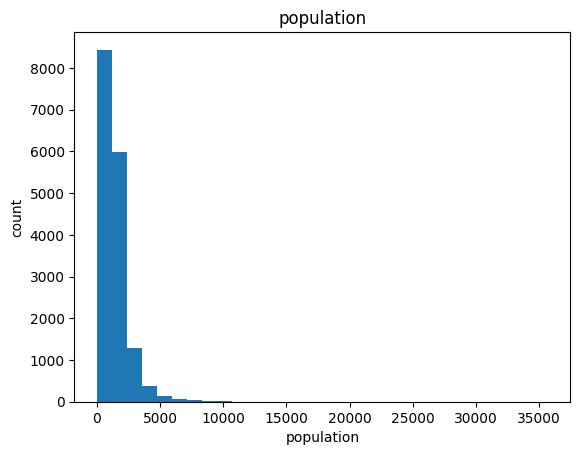

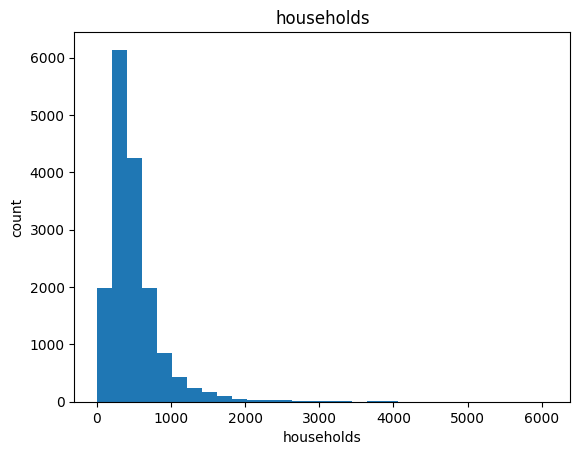

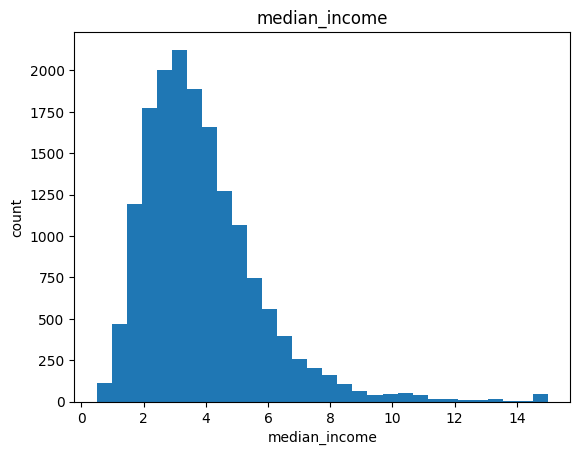

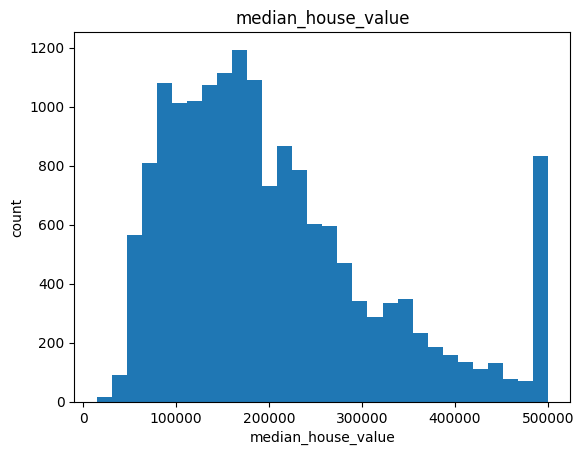

In [7]:
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    plt.figure()
    plt.hist(train_data[col].dropna(), bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

## Correlation heatmap on training data

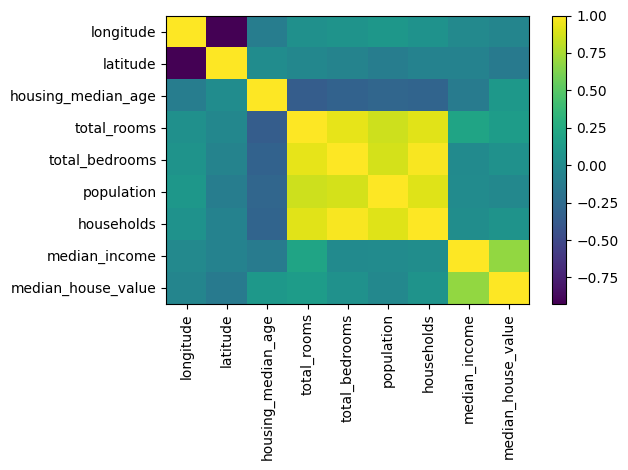

In [8]:
corr = train_data.corr(numeric_only=True)
plt.figure()
plt.imshow(corr.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.tight_layout()
plt.show()

## Log transform skewed features

In [9]:
skew_cols = [c for c in ["total_rooms","total_bedrooms","population","households"] if c in train_data.columns]
for c in skew_cols:
    train_data[c] = np.log1p(train_data[c])
train_data.shape

(16346, 10)

## Histograms after log transform

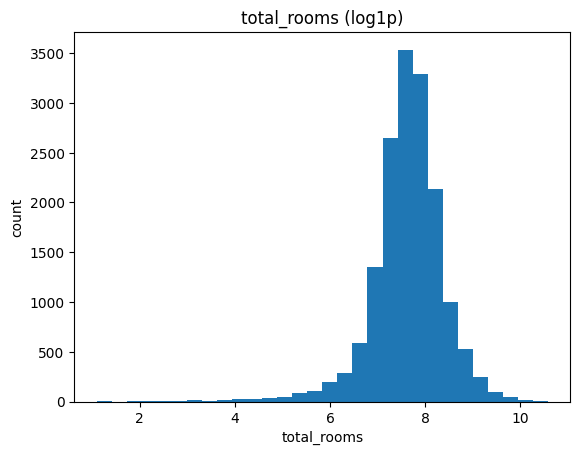

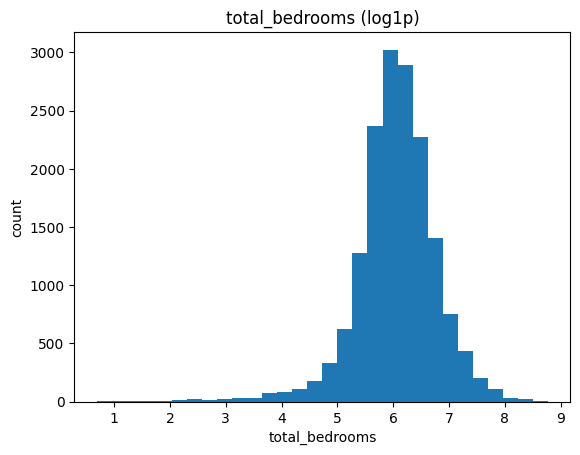

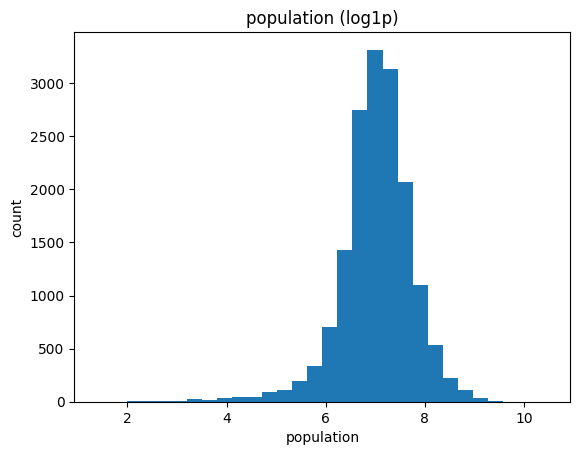

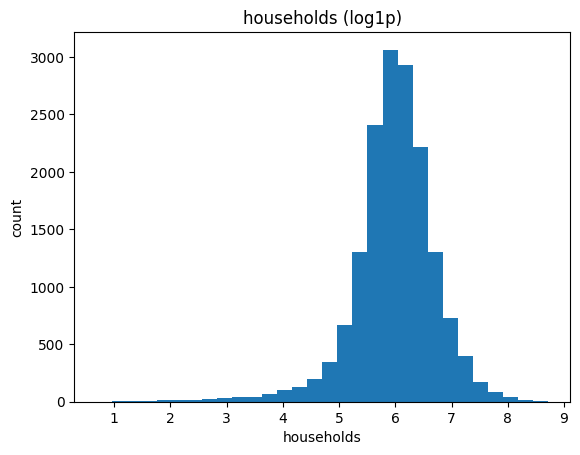

In [10]:
for col in skew_cols:
    plt.figure()
    plt.hist(train_data[col].dropna(), bins=30)
    plt.title(col + " (log1p)")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

## One‑hot encode categorical feature if present

In [11]:
cat_cols = train_data.select_dtypes(include=["object","category"]).columns.tolist()
if "ocean_proximity" in train_data.columns:
    dummies = pd.get_dummies(train_data["ocean_proximity"], prefix="ocean_proximity", drop_first=False)
    train_data = pd.concat([train_data.drop(columns=["ocean_proximity"]), dummies], axis=1)
else:
    for c in cat_cols:
        train_data = pd.concat([train_data.drop(columns=[c]), pd.get_dummies(train_data[c], prefix=c, drop_first=False)], axis=1)
train_data.shape

(16346, 14)

## Feature engineering: bedroom_ratio and rooms_per_household

In [12]:
if set(["total_bedrooms","total_rooms"]).issubset(train_data.columns):
    train_data["bedroom_ratio"] = train_data["total_bedrooms"] / train_data["total_rooms"]
if set(["total_rooms","households"]).issubset(train_data.columns):
    train_data["rooms_per_household"] = train_data["total_rooms"] / train_data["households"]
train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(0.0)
train_data.shape

(16346, 16)

## Correlation heatmap after feature engineering

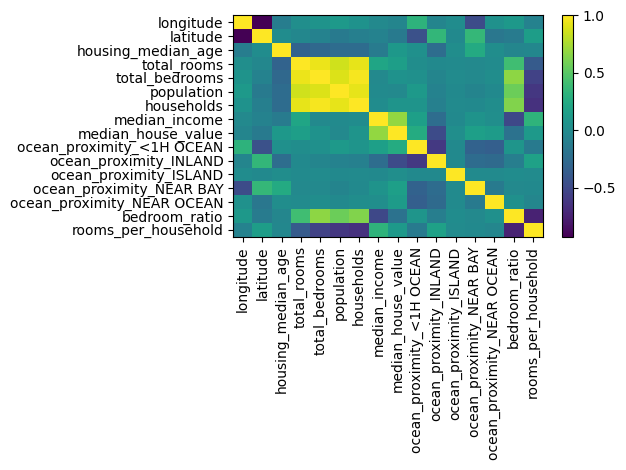

In [13]:
corr2 = train_data.corr(numeric_only=True)
plt.figure()
plt.imshow(corr2.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr2.columns)), corr2.columns, rotation=90)
plt.yticks(range(len(corr2.index)), corr2.index)
plt.tight_layout()
plt.show()

## Define preprocessing function for train/test consistency

In [14]:
def preprocess(df):
    df2 = df.copy()
    if "total_rooms" in df2.columns:
        df2["total_rooms"] = np.log1p(df2["total_rooms"])
    if "total_bedrooms" in df2.columns:
        df2["total_bedrooms"] = np.log1p(df2["total_bedrooms"])
    if "population" in df2.columns:
        df2["population"] = np.log1p(df2["population"])
    if "households" in df2.columns:
        df2["households"] = np.log1p(df2["households"])
    cat_cols_df = df2.select_dtypes(include=["object","category"]).columns.tolist()
    if "ocean_proximity" in df2.columns:
        dummies = pd.get_dummies(df2["ocean_proximity"], prefix="ocean_proximity", drop_first=False)
        df2 = pd.concat([df2.drop(columns=["ocean_proximity"]), dummies], axis=1)
    else:
        for c in cat_cols_df:
            df2 = pd.concat([df2.drop(columns=[c]), pd.get_dummies(df2[c], prefix=c, drop_first=False)], axis=1)
    if set(["total_bedrooms","total_rooms"]).issubset(df2.columns):
        df2["bedroom_ratio"] = df2["total_bedrooms"] / df2["total_rooms"]
    if set(["total_rooms","households"]).issubset(df2.columns):
        df2["rooms_per_household"] = df2["total_rooms"] / df2["households"]
    df2 = df2.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return df2

## Apply preprocessing to train and test then align columns

In [15]:
X_train_proc = preprocess(X_train)
X_test_proc = preprocess(X_test)
X_train_proc, X_test_proc = X_train_proc.align(X_test_proc, join="outer", axis=1, fill_value=0.0)
X_train_proc.shape, X_test_proc.shape

((16346, 15), (4087, 15))

## Scale numeric features for linear regression

In [16]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_proc)
X_test_s = scaler.transform(X_test_proc)
X_train_s.shape, X_test_s.shape

((16346, 15), (4087, 15))

## Train linear regression

In [18]:
linreg = LinearRegression()
linreg.fit(X_train_s, y_train)
y_pred_lr = linreg.predict(X_test_s)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(r2_lr, rmse_lr, mae_lr)

0.6687407117584969 4530030653.760368 48660.75657971958


## Train random forest (default) on unscaled features

In [20]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train_proc, y_train)
y_pred_rf = rf.predict(X_test_proc)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(r2_rf, rmse_rf, mae_rf)

0.8194040647914272 2469682063.2027693 32560.91575972596


## Hyperparameter tuning with GridSearchCV

In [22]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=0)
grid.fit(X_train_proc, y_train)
best_rf = grid.best_estimator_
y_pred_brf = best_rf.predict(X_test_proc)
r2_brf = r2_score(y_test, y_pred_brf)
rmse_brf = mean_squared_error(y_test, y_pred_brf)
mae_brf = mean_absolute_error(y_test, y_pred_brf)
print(grid.best_params_)
print(r2_brf, rmse_brf, mae_brf)

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
0.8209288072868344 2448830933.9259067 32439.232425790953


## Compare model metrics

In [23]:
results = pd.DataFrame({
    "model": ["LinearRegression", "RandomForest", "BestRandomForest"],
    "R2": [r2_lr, r2_rf, r2_brf],
    "RMSE": [rmse_lr, rmse_rf, rmse_brf],
    "MAE": [mae_lr, mae_rf, mae_brf]
})
results

,model,R2,RMSE,MAE
0,LinearRegression,0.668741,4.530031e+09,48660.756580
1,RandomForest,0.819404,2.469682e+09,32560.915760
2,BestRandomForest,0.820929,2.448831e+09,32439.232426


## Predict on new data

In [28]:
X_new = X_test.head()
X_new_proc = preprocess(X_new)
X_new_proc = X_new_proc.reindex(columns=X_train_proc.columns, fill_value=0.0)

try:
    model = best_rf
except NameError:
    try:
        model = rf
    except NameError:
        model = linreg

X_in = X_new_proc if hasattr(model, "feature_importances_") else scaler.transform(X_new_proc)
preds = model.predict(X_in)
pd.DataFrame({"predicted_median_house_value": preds})

,predicted_median_house_value
0,241977.049145
1,150151.619638
2,193839.526543
3,138719.801515
4,159256.148103
